In [1]:
import os
import gymnasium
from gymnasium.spaces import Box, Tuple, Discrete
import numpy as np
import torch

import ray 
from ray import tune
from ray.rllib.algorithms.ppo import PPOConfig
from gym_platform.envs.platform_env import PlatformEnv

2023-12-15 18:29:15,980	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-15 18:29:16,805	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-15 18:29:17,734	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.


# Preprocessing

* Create a wrapper for the environment in order to make it compatible with Gymnasium.
* Scale the actions in the [-1, 1] range.
* Scale the observations in the [0, 1] range and change the observation space.


In [2]:
class ToGymnasium(gymnasium.Env):
    def __init__(self, env):
        self.env = env
        # self.observation_space = convert_space(self.env.observation_space)

        # flatten the observation space
        self.observation_space = Box(
            low=np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
            high=np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
            dtype=np.float64,
        )

        self.action_scale = [30., 720., 430.]
        self.action_space = Tuple([
            Discrete(3),
            Tuple([
                Box(low=-1., high=1., shape=(1,), dtype=np.float32),
                Box(low=-1., high=1., shape=(1,), dtype=np.float32),
                Box(low=-1., high=1., shape=(1,), dtype=np.float32),
            ])
        ])

    def reset(self, *, seed: int | None = None, options: dict | None = None):
        state = self.env.reset()
        state = np.append(state[0], state[1]/200.)
        return state, {}

    def step(self, action):
        # rescale action
        action = (
            action[0],
            [(x + 1) * scale / 2 for x, scale in zip(action[1], self.action_scale)],
        )

        state, reward, done, info = self.env.step(action)
        state = np.append(state[0], state[1]/200.)
        done = bool(done)
        return state, reward, done, done, info
    
    def render(self):
        return self.env.render()
    
    def close(self):
        return self.env.close()

tune.register_env(
    'Platform-v0',
    lambda _: ToGymnasium(PlatformEnv()),
)


In [3]:
ray.init(num_cpus=4, num_gpus=1)
# ray.init(local_mode=True)

2023-12-15 18:29:21,878	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.12
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8265


# PPO parameters

* Use GAE with lamda: 0.95
* Gamma: 0.99
* Learning rate: 1e-4
* Training batch size: 4.000
* SGD minibatch size: 200
* Clip value: 0.2
* Model (policy and value) with 3 hidder layers of size 256

## Grid search

* kl coefficient: 0, 0.2
* entropy coefficient: 0, 0.1

In [4]:
config = (
    PPOConfig()
    .environment('Platform-v0')
    .framework('torch')
    .rollouts(num_rollout_workers=3)
    .resources(
        num_learner_workers=1,
        num_cpus_per_learner_worker=1,
        num_gpus_per_learner_worker=1,
    )
    .rl_module(
        _enable_rl_module_api=True,
    )
    .training(
        _enable_learner_api=True,
        gamma=0.99,
    )
)

search_params = {
    'kl_coeff': tune.grid_search([0., 0.2]),
    'entropy_coeff': tune.grid_search([0., 0.1]),
}

config.update_from_dict({
    'disable_env_checking': True,
    'use_kl_loss': True,
    'use_gae': True,
    "lr": 1e-4,
    'lambda_': 0.95,
    'sgd_minibatch_size': 200,
    'train_batch_size': 4000,
    'clip_param': 0.2,
    'model': {'fcnet_hiddens': [256, 256, 265]}
})
config.update_from_dict(search_params)


# Grid Search

We run the grid search for 25 iterations or we stop if the mean episode reward is 1.

In [5]:
results = tune.run(
    'PPO',
    name='hyperparam_search',
    config=config.to_dict(),
    metric="episode_reward_mean",
    search_alg='random',
    stop={"training_iteration": 25, "episode_reward_mean": 1},
    local_dir=os.path.abspath("ray_results"),
    checkpoint_freq=-1,
    checkpoint_at_end=True,
)


2023-12-15 18:29:24,462	INFO tune.py:586 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-12-15 18:29:24,473	WARNING __init__.py:10 -- A3C has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
2023-12-15 18:29:24,475	WARNING __init__.py:10 -- A2C has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, 

(pid=313297) 2023-12-15 18:29:32,531	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
(RolloutWorker pid=313340) 2023-12-15 18:29:44,860	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! S

Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,timers
PPO_Platform-v0_1c3de_00000,100000,"{'ObsPreprocessorConnector_ms': 0.015567520330118578, 'StateBufferConnector_ms': 0.17380062923874967, 'ViewRequirementAgentConnector_ms': 0.9551396550134171}","{'num_env_steps_sampled': 100000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 100000, 'num_agent_steps_trained': 0}",{},2.90843,{},0.337999,0.285766,0.103493,1376,"{'learner': {'__all__': {'num_agent_steps_trained': 200.0, 'num_env_steps_trained': 4000.0, 'total_loss': 0.002657035226778438}, 'default_policy': {'total_loss': 0.002657035226778438, 'policy_loss': 0.0013679506870297093, 'vf_loss': 0.0012890850137531136, 'vf_loss_unclipped': 0.0012890850137531136, 'vf_explained_var': 0.8339975596467654, 'entropy': 3.7664799372355144, 'mean_kl_loss': 0.006611736435785739, 'default_optimizer_lr': 0.00010000000000000002, 'curr_lr': 0.0001, 'curr_entropy_coeff': 0.0, 'curr_kl_coeff': 0.0}}, 'num_env_steps_sampled': 100000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 100000, 'num_agent_steps_trained': 0}",100000,0,100000,4000,48.87,0,0,0,0,3,0,0,0,"{'cpu_util_percent': 77.96982758620688, 'ram_util_percent': 67.40517241379308}",{},{},{},"{'mean_raw_obs_processing_ms': 3.088794464577627, 'mean_inference_ms': 6.963253958078992, 'mean_action_processing_ms': 0.9637157254644332, 'mean_env_wait_ms': 28.163087345726222, 'mean_env_render_ms': 0.0}","{'training_iteration_time_ms': 71545.912, 'sample_time_ms': 59284.613, 'synch_weights_time_ms': 16.044}"
PPO_Platform-v0_1c3de_00001,100000,"{'ObsPreprocessorConnector_ms': 0.0203400908015173, 'StateBufferConnector_ms': 0.22497150958007656, 'ViewRequirementAgentConnector_ms': 1.0648244577042127}","{'num_env_steps_sampled': 100000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 100000, 'num_agent_steps_trained': 0}",{},2.58296,{},0.313475,0.122114,0,1549,"{'learner': {'__all__': {'num_agent_steps_trained': 200.0, 'num_env_steps_trained': 4000.0, 'total_loss': -7.6739827791849775}, 'default_policy': {'total_loss': -7.6739827791849775, 'policy_loss': 0.01154693123884499, 'vf_loss': 0.009643166017097731, 'vf_loss_unclipped': 0.009643166017097731, 'vf_explained_var': 0.05565164496501287, 'entropy': 76.9517280960083, 'mean_kl_loss': 0.018210286293513036, 'default_optimizer_lr': 0.00010000000000000002, 'curr_lr': 0.0001, 'curr_entropy_coeff': 0.1, 'curr_kl_coeff': 0.0}}, 'num_env_steps_sampled': 100000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 100000, 'num_agent_steps_trained': 0}",100000,0,100000,4000,47.8052,0,0,0,0,3,0,0,0,"{'cpu_util_percent': 78.81848739495797, 'ram_util_percent': 67.69495798319326}",{},{},{},"{'mean_raw_obs_processing_ms': 2.742239062978365, 'mean_inference_ms': 6.5195974954248275, 'mean_action_processing_ms': 0.9127129192074249, 'mean_env_wait_ms': 27.30748426213387, 'mean_env_render_ms': 0.0}","{'training_iteration_time_ms': 65323.991, 'sample_time_ms': 53652.672, 'synch_weights_time_ms': 17.252}"
PPO_Platform-v0_1c3de_00002,100000,"{'ObsPreprocessorConnector_ms': 0.016610147702347245, 'StateBufferConnector_ms': 0.10345419514632598, 'ViewRequirementAgentConnector_ms': 0.9701760289919723}","{'num_env_steps_sampled': 100000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 100000, 'num_agent_steps_trained': 0}",{},8.93736,{},1,0.982504,0.244923,447,"{'learner': {'__all__': {'num_agent_steps_trained': 200.0, 'num_env_steps_trained

(PPO pid=313297) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/seiras/Learning/indta-deep/ray_results/hyperparam_search/PPO_Platform-v0_1c3de_00000_0_entropy_coeff=0.0000,kl_coeff=0.0000_2023-12-15_18-29-25/checkpoint_000000)
(pid=315637) 2023-12-15 18:57:51,913	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
(RolloutWorker pid=315668) 2023-12-15 18:58:00,521	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still us

# Best parameters

In [6]:
from pprint import pprint

best_result = results.get_best_trial(mode='max')

print("Best performing trial's final set of hyperparameters:\n")
pprint({k: v for k, v in best_result.config.items() if k in search_params})

Best performing trial's final set of hyperparameters:

{'entropy_coeff': 0.0, 'kl_coeff': 0.2}


# Training

We run the training for 100 iterations or we stop if the mean episode reward is 1.

In [7]:
results = tune.run(
    'PPO',
    name='training',
    config=best_result.config,
    metric="episode_reward_mean",
    search_alg='random',
    stop={"training_iteration": 100, "episode_reward_mean": 1},
    local_dir=os.path.abspath("ray_results"),
    checkpoint_freq=-1,
    checkpoint_at_end=True,
)


2023-12-15 20:26:16,214	INFO tune.py:586 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(pid=322814) 2023-12-15 20:26:22,528	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
(RolloutWorker pid=322851) 2023-12-15 20:26:32,175	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! S

Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,timers
PPO_Platform-v0_6f168_00000,244000,"{'ObsPreprocessorConnector_ms': 0.016383502794348675, 'StateBufferConnector_ms': 0.10054842558278099, 'ViewRequirementAgentConnector_ms': 0.9515887812564248}","{'num_env_steps_sampled': 244000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 244000, 'num_agent_steps_trained': 0}",{},9.14645,{},1,1,1,437,"{'learner': {'__all__': {'num_agent_steps_trained': 200.0, 'num_env_steps_trained': 4000.0, 'total_loss': -0.009713520000029044}, 'default_policy': {'total_loss': -0.009713520000029044, 'policy_loss': -0.01870271679532986, 'vf_loss': 1.3498228760984906e-06, 'vf_loss_unclipped': 1.3498228760984906e-06, 'vf_explained_var': 0.9999852432807287, 'entropy': 3.4685148406028747, 'mean_kl_loss': 0.0394083283898605, 'default_optimizer_lr': 0.00010000000000000002, 'curr_lr': 0.0001, 'curr_entropy_coeff': 0.0, 'curr_kl_coeff': 0.34210461378097534}}, 'num_env_steps_sampled': 244000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 244000, 'num_agent_steps_trained': 0}",244000,0,244000,4000,66.8801,0,0,0,0,3,0,0,0,"{'cpu_util_percent': 77.46823529411765, 'ram_util_percent': 68.36941176470586}",{},{},{},"{'mean_raw_obs_processing_ms': 2.5812670553429986, 'mean_inference_ms': 7.303765176816603, 'mean_action_processing_ms': 1.010538174909928, 'mean_env_wait_ms': 27.89703357426141, 'mean_env_render_ms': 0.0}","{'training_iteration_time_ms': 63604.89, 'sample_time_ms': 51068.733, 'synch_weights_time_ms': 18.52}"


(PPO pid=322814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/seiras/Learning/indta-deep/ray_results/training/PPO_Platform-v0_6f168_00000_0_2023-12-15_20-26-16/checkpoint_000000)
2023-12-15 21:33:27,439	INFO tune.py:1047 -- Total run time: 4031.23 seconds (4030.88 seconds for the tuning loop).


In [8]:
from ray.rllib.policy.policy import Policy

policy = Policy.from_checkpoint(results.get_last_checkpoint().path)['default_policy']
policy.export_checkpoint('last_policy')
policy.model


PPOTorchRLModule(
  (encoder): TorchActorCriticEncoder(
    (actor_encoder): TorchMLPEncoder(
      (net): TorchMLP(
        (mlp): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): Tanh()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Tanh()
          (4): Linear(in_features=256, out_features=265, bias=True)
          (5): Tanh()
        )
      )
    )
    (critic_encoder): TorchMLPEncoder(
      (net): TorchMLP(
        (mlp): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): Tanh()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Tanh()
          (4): Linear(in_features=256, out_features=265, bias=True)
          (5): Tanh()
        )
      )
    )
  )
  (pi): TorchMLPHead(
    (net): TorchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=265, out_features=9, bias=True)
      )
    )
  )
  (vf): TorchMLPHead(
    (

In [9]:
ray.shutdown()

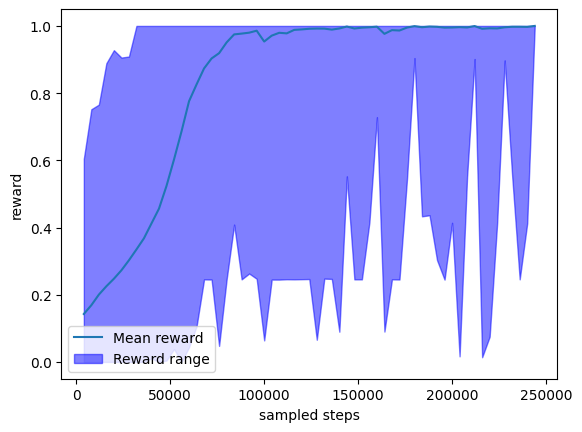

In [39]:
import matplotlib.pyplot as plt

data = list(results.trial_dataframes.values())[0]

plt.plot(data['num_agent_steps_sampled'], data['episode_reward_mean'], label='Mean reward')
plt.fill_between(data['num_agent_steps_sampled'], data['episode_reward_min'], data['episode_reward_max'], color='blue', alpha=0.5, label='Reward range')

plt.xlabel('sampled steps')
plt.ylabel('reward')
plt.legend()

plt.show()